# Compare logistic regression models of several mutations for a) covariates only and b) covariates with gene expression data to determine marginal gain using gene expression data 

In [59]:
import os
import urllib
import random
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, Imputer, FunctionTransformer
from sklearn.feature_selection import SelectKBest, VarianceThreshold
from statsmodels.robust.scale import mad
from IPython.display import display
import gc

In [60]:
%matplotlib inline
plt.style.use('seaborn-notebook')

## Load Data

In [61]:
%%time
path = os.path.join('..', '..', 'download', 'covariates.tsv')
covariates = pd.read_table(path, index_col=0)

CPU times: user 94.6 ms, sys: 11.1 ms, total: 106 ms
Wall time: 133 ms


In [62]:
%%time
path = os.path.join('..', '..', 'download', 'expression-matrix.tsv.bz2')
expression = pd.read_table(path, index_col=0)

CPU times: user 3min 21s, sys: 5.21 s, total: 3min 26s
Wall time: 3min 29s


In [63]:
%%time
path = os.path.join('..','..','download', 'mutation-matrix.tsv.bz2')
Y = pd.read_table(path, index_col=0)

CPU times: user 1min 51s, sys: 5.08 s, total: 1min 56s
Wall time: 1min 57s


In [64]:
X = {}
X['model a'] = covariates
X['model b'] = pd.concat([covariates,expression], axis=1)
for k in ['model a','model b']:
    print(X[k].shape)

(7306, 70)
(7306, 20600)


In [65]:
mutations = {
    '7157': 'TP53',   # tumor protein p53
    '7428': 'VHL',    # von Hippel-Lindau tumor suppressor
    '29126': 'CD274', # CD274 molecule
    '672': 'BRCA1',   # BRCA1, DNA repair associated
    '675': 'BRCA2',   # BRCA2, DNA repair associated
    '238': 'ALK',     # anaplastic lymphoma receptor tyrosine kinase
    '4221': 'MEN1',   # menin 1
    '5979': 'RET',    # ret proto-oncogene
}

## Median absolute deviation feature selection

In [66]:
def fs_mad(x, y):
    """    
    Get the median absolute deviation (MAD) for each column of x
    """
    scores = mad(x) 
    return scores, np.array([np.NaN]*len(scores))

## Define pipeline and Cross validation model fitting

In [67]:
# Parameter Sweep for Hyperparameters

param_grid = {
    'classify__loss': ['log'],
    'classify__penalty': ['elasticnet'],
    'classify__alpha': [10 ** x for x in range(-4, 2)],
    'classify__l1_ratio': [0, 0.05, 0.1, 0.2, 0.5],
}

expression_feats = Pipeline(steps=[
    ('dim_red', FunctionTransformer(lambda X: X[:,covariates.shape[1]:])),
    ('select', SelectKBest(fs_mad,2000)),
])

covariate_feats = Pipeline(steps=[
    ('dim_red', FunctionTransformer(lambda X: X[:,:covariates.shape[1]])),
])

combo_pipeline = Pipeline([
    ('imputer', Imputer()),
    ('standardize', StandardScaler()),
    ('features', FeatureUnion([
        ('covariates_feats', covariate_feats),           
        ('expression_feats', expression_feats)
    ])),
    ('classify', SGDClassifier(random_state=0, class_weight='balanced'))
])

covariates_pipeline = Pipeline(steps=[
    ('imputer', Imputer()),
    ('standardize', StandardScaler()),
    ('classify', SGDClassifier(random_state=0, class_weight='balanced'))
])

In [68]:
cv_pipeline = {}
cv_pipeline['model a'] = GridSearchCV(estimator=covariates_pipeline, param_grid=param_grid, scoring='roc_auc')
cv_pipeline['model b'] = GridSearchCV(estimator=combo_pipeline, param_grid=param_grid, scoring='roc_auc')

## Functions to get statistics for a given model 

In [69]:
# Get statistics for a given model. 

def get_aurocs(X, y, pipeline, series, model_type):
    """
    Fit the classifier for the given mutation (y) and output predictions for it
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
    pipeline.fit(X=X_train, y=y_train)
    y_pred_train = pipeline.decision_function(X_train)
    y_pred_test = pipeline.decision_function(X_test)
    cv_score_df = grid_scores_to_df(pipeline.grid_scores_)
    coeff_df = get_coeffs(pipeline, X_train, model_type)
    n_pos, n_neg = get_sign_coeffs(coeff_df)
    cov_ranks = get_ranks_covariates_feat(coeff_df)
    series['mean_cv_auroc'] = cv_score_df.score.max()
    series['training_auroc'] = roc_auc_score(y_train, y_pred_train)
    series['testing_auroc'] = roc_auc_score(y_test, y_pred_test)
    series['best_l1_ratio'] = pipeline.best_params_['classify__l1_ratio']
    series['best_alpha'] = pipeline.best_params_['classify__alpha']
    series['n_pos_coeffs'] = n_pos
    series['n_neg_coeffs'] = n_neg
    series['n_positive_mutation'] = sum(y==1)
    series['n_negative_mutation'] = sum(y==0)
    series['cum_rank_cov_feat'] = cov_ranks.sum()
    series['median_rank_cov_feat'] = np.median(cov_ranks)
    series['mean_rank_cov_feat'] = np.mean(cov_ranks)
    return series

def grid_scores_to_df(grid_scores):
    """
    Convert a sklearn.grid_search.GridSearchCV.grid_scores_ attribute to 
    a tidy pandas DataFrame where each row is a hyperparameter-fold combinatination.
    """
    rows = list()
    for grid_score in grid_scores:
        for fold, score in enumerate(grid_score.cv_validation_scores):
            row = grid_score.parameters.copy()
            row['fold'] = fold
            row['score'] = score
            rows.append(row)
    df = pd.DataFrame(rows)
    return df

def get_coeffs(pipeline, X_train, model_type):
    """
    Get a dataframe with the training coefficients 
    """
    final_pipeline = pipeline.best_estimator_
    final_classifier = final_pipeline.named_steps['classify']
    
    # Get indices of features
    if model_type == 'model a': 
        select_indices = list(range(len(covariates.columns.values)))
    else:
        select_indices = final_pipeline.named_steps['features'].transform(
            np.arange(len(X_train.columns)).reshape(1, -1)
        ).tolist()
        select_indices = [x for sublist in select_indices for x in sublist]
    
    # Make df features, weights
    coef_df = pd.DataFrame.from_items([
        ('feature', X_train.columns[select_indices]),
        ('weight', final_classifier.coef_[0]),
    ])

    return coef_df

def get_sign_coeffs(coef_df):
    return (coef_df.weight>0).sum(), (coef_df.weight<0).sum()

def get_ranks_covariates_feat(coef_df):
    coef_df['abs'] = coef_df['weight'].abs()
    coef_df = coef_df.sort_values('abs', ascending=False)
    
    def RepresentsInt(s):
        try: 
            int(s)
            return True
        except ValueError:
            return False

    coef_df['is_cov_feat'] = [not RepresentsInt(x) for x in coef_df['feature']]
    ranks = np.flatnonzero(coef_df['is_cov_feat'])
    return ranks

auroc_dfs = {}

## Train the models.

In [70]:
%%time
# Train model a: covariates only.
warnings.filterwarnings("ignore") # ignore deprecation warning for grid_scores_
rows = list()
for m in list(mutations):
    series = pd.Series()
    series['mutation'] = m
    series['symbol'] = mutations[m]
    rows.append(get_aurocs(X['model a'], Y[m], cv_pipeline['model a'], series, 'model a'))
auroc_dfs['model a'] = pd.DataFrame(rows)
auroc_dfs['model a'].sort_values(['symbol', 'testing_auroc'], ascending=[True, False], inplace=True)
display(auroc_dfs['model a'])

,mutation,symbol,mean_cv_auroc,training_auroc,testing_auroc,best_l1_ratio,best_alpha,n_pos_coeffs,n_neg_coeffs,n_positive_mutation,n_negative_mutation,cum_rank_cov_feat,median_rank_cov_feat,mean_rank_cov_feat
7,238,ALK,0.867753,0.836069,0.835344,0.20,0.1,4,6,138,7168,2415,34.5,34.5
5,672,BRCA1,0.837940,0.855724,0.801430,0.10,0.1,10,21,136,7170,2415,34.5,34.5
2,675,BRCA2,0.808354,0.799134,0.831192,0.50,0.1,3,0,237,7069,2415,34.5,34.5
1,29126,CD274,0.927592,0.885474,0.864692,0.05,1.0,4,0,19,7287,2415,34.5,34.5
4,4221,MEN1,0.772510,0.865684,0.768484,0.00,0.1,29,41,57,7249,2415,34.5,34.5
0,5979,RET,0.891249,0.806939,0.859125,0.20,0.1,4,1,117,7189,2415,34.5,34.5
6,7157,TP53,0.846163,0.846220,0.848195,0.00,0.1,32,38,2587,4719,2415,34.5,34.5
3,7428,VHL,0.985708,0.983252,0.973353,0.05,0.1,10,35,135,7171,2415,34.5,34.5


CPU times: user 1min 28s, sys: 2.77 s, total: 1min 30s
Wall time: 46.1 s


In [71]:
%%time
# Train model b: covariates with gene expression data.
warnings.filterwarnings("ignore") # ignore deprecation warning for grid_scores_
rows = list()
for m in list(mutations):
    series = pd.Series()
    series['mutation'] = m
    series['symbol'] = mutations[m]
    rows.append(get_aurocs(X['model b'], Y[m], cv_pipeline['model b'], series, 'model b'))
auroc_dfs['model b'] = pd.DataFrame(rows)
auroc_dfs['model b'].sort_values(['symbol', 'testing_auroc'], ascending=[True, False], inplace=True)

CPU times: user 2h 23min 5s, sys: 1h 17min 5s, total: 3h 40min 11s
Wall time: 3h 39min 58s


In [72]:
auroc_dfs['model a']['model'] = 'covariates_only'
auroc_dfs['model b']['model'] = 'combined'
auroc_df = pd.concat([auroc_dfs['model a'],auroc_dfs['model b']])
auroc_df.to_csv("./auroc_df.tsv", sep="\t", float_format="%.3g", index=False)
display(auroc_df)

,mutation,symbol,mean_cv_auroc,training_auroc,testing_auroc,best_l1_ratio,best_alpha,n_pos_coeffs,n_neg_coeffs,n_positive_mutation,n_negative_mutation,cum_rank_cov_feat,median_rank_cov_feat,mean_rank_cov_feat,model
7,238,ALK,0.867753,0.836069,0.835344,0.20,0.10,4,6,138,7168,2415,34.5,34.500000,covariates_only
5,672,BRCA1,0.837940,0.855724,0.801430,0.10,0.10,10,21,136,7170,2415,34.5,34.500000,covariates_only
2,675,BRCA2,0.808354,0.799134,0.831192,0.50,0.10,3,0,237,7069,2415,34.5,34.500000,covariates_only
1,29126,CD274,0.927592,0.885474,0.864692,0.05,1.00,4,0,19,7287,2415,34.5,34.500000,covariates_only
4,4221,MEN1,0.772510,0.865684,0.768484,0.00,0.10,29,41,57,7249,2415,34.5,34.500000,covariates_only
0,5979,RET,0.891249,0.806939,0.859125,0.20,0.10,4,1,117,7189,2415,34.5,34.500000,covariates_only
6,7157,TP53,0.846163,0.846220,0.848195,0.00,0.10,32,38,2587,4719,2415,34.5,34.500000,covariates_only
3,7428,VHL,0.985708,0.983252,0.973353,0.05,0.10,10,35,135,7171,2415,34.5,34.500000,covariates_only
7,238,ALK,0.868948,0.842398,0.844386,0.50,0.10,5,3,138,7168,94171,1388.5,1345.300000,combined
5,672,BRCA1,0.827729,0.866105,0.806641,0.50,0.10,15,8,136,7170,95099,1392.5,1358.557143,combined


In [74]:
auroc_dfs['model a'] = auroc_dfs['model a'].drop('model',axis=1)
auroc_dfs['model b'] = auroc_dfs['model b'].drop('model',axis=1)
auroc_dfs['diff_models_ab'] = auroc_dfs['model b'].loc[:,'mean_cv_auroc':]-auroc_dfs['model a'].loc[:,'mean_cv_auroc':]
auroc_dfs['diff_models_ab'][['mutation', 'symbol']] = auroc_dfs['model b'].loc[:, ['mutation', 'symbol']]
auroc_dfs['diff_models_ab']

,mean_cv_auroc,training_auroc,testing_auroc,best_l1_ratio,best_alpha,n_pos_coeffs,n_neg_coeffs,n_positive_mutation,n_negative_mutation,cum_rank_cov_feat,median_rank_cov_feat,mean_rank_cov_feat,mutation,symbol
7,0.001195,0.006330,0.009043,0.30,0.00,1,-3,0,0,91756,1354.0,1310.800000,238,ALK
5,-0.010211,0.010381,0.005211,0.40,0.00,5,-13,0,0,92684,1358.0,1324.057143,672,BRCA1
2,-0.001289,-0.000455,-0.004586,-0.40,0.90,1,1,0,0,89108,1354.0,1272.971429,675,BRCA2
1,-0.023176,0.054856,-0.181006,0.05,0.00,5,2,0,0,89773,1356.0,1282.471429,29126,CD274
4,0.035437,0.110134,-0.052629,0.20,0.00,31,16,0,0,89945,1374.0,1284.928571,4221,MEN1
0,0.002323,-0.306939,-0.359125,0.00,0.90,-4,-1,0,0,92361,1353.0,1319.442857,5979,RET
6,0.084100,0.096764,0.080753,0.05,0.00,215,83,0,0,70090,1411.0,1001.285714,7157,TP53
3,0.007011,0.010456,-0.021719,0.00,-0.09,626,678,0,0,62286,894.5,889.800000,7428,VHL


# Covariates only vs covariates+expression model

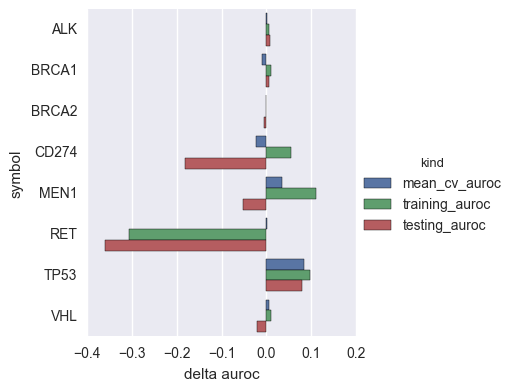

In [75]:
plot_df = pd.melt(auroc_dfs['diff_models_ab'], id_vars='symbol', value_vars=['mean_cv_auroc', 'training_auroc', 'testing_auroc'], var_name='kind', value_name='delta auroc')
grid = sns.factorplot(y='symbol', x='delta auroc', hue='kind', data=plot_df, kind="bar")